# Annotating spectra with spot-intensity

---

**Updated on:** 2023-09-15

> Author(s): Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): .mzML file to be annotated, .csv file containing list of spots
> Output file(s): .mzML file containing annotated MS1 Spectra
> Dependencies: pandas, numpy, matplotlib, ipympl, pathlib, pyopenms

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [25]:
import pyopenms as oms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipympl
from pyopenms.plotting import plot_spectrum
from pathlib import Path
%matplotlib widget

## User Input

In [26]:
# Filepath of the mzml file to be annotated with bioactivity.
mzml_filepath=Path(r"test_mzml\example1.mzML")

# Filepath of the .csv file containing the spotlist.
spotlist_filepath=Path(r"output\output_concat.csv")

# Folderpath to which the final result should be saved.
outputfolder=Path(r"output")

# Scaling-Factor to scale the spot-intensity to.
intensity_scalingfactor=10e6

# m/z value at which the scaled spot intensity should be saved.
spot_mz=1000

In [27]:
# Create new MS Experiment and load mzml file to it.
exp=oms.MSExperiment()
oms.MzMLFile().load(mzml_filepath.as_posix(),exp)

# Read the .csv containing the spot list and sort it by retention time
spots=pd.read_csv(spotlist_filepath,index_col=0)
spots=spots.sort_values("RT")

In [28]:
spec_list=[]
rt_list=[]
int_list=[]
# Loop through all Spectra in the mzml file.
for spectrum in exp:
    # Check if the spectrum is MS1
    if spectrum.getMSLevel()==1:

        # Get the RT
        rt_val=spectrum.getRT()
        
        # Index the spot with the closest, shorter RT value compared to the RT of the spectrum.
        prev_spot=spots[spots["RT"]<=rt_val].iloc[-1]
        
        # Index the spot with the closest, longer RT value compared to the RT of the spectrum
        try:        
            next_spot=spots[spots["RT"]>rt_val].iloc[0]
        except:
            # If there is no higher RT in the spotlist, take the next smallest one.
            next_spot=prev_spot
        
        # Interpolate the spot intensity for the RT value
        interp_intensity=np.interp(rt_val,[prev_spot["RT"],next_spot["RT"]],[prev_spot["spot_intensity"],next_spot["spot_intensity"]])
        
        # Append the array of peak-m/z values with the one specified to save the spot intensity
        peak_mz=np.append(spectrum.get_peaks()[0],spot_mz)
        # Append the array of peak-intensities with the scaled version of the interpolated spot intensity
        peak_int=np.append(spectrum.get_peaks()[1],interp_intensity*intensity_scalingfactor)
        # Save the new peak arrays in the spectrum.
        spectrum.set_peaks((peak_mz,peak_int))
    
    # Append current spectrum to the modified list of spectra
    spec_list.append(spectrum)
    # Append values for use in chromatogramm plot
    rt_list.append(rt_val)
    int_list.append(interp_intensity)

# Save the spectra-list to the MS Experiment
exp.setSpectra(spec_list)

In [29]:
# Create the output-folder, if it does not exists
if not outputfolder.exists():
    outputfolder.mkdir()

# Genereate the new filename and save the MS Experiment to a .mzML file.
output_filename=outputfolder/Path(mzml_filepath.name.split(".")[0]+"_spotint.mzML")
oms.MzMLFile().store(output_filename.as_posix(),exp)

MS-Level:  1


<Axes: xlabel='m/z', ylabel='Intensity'>

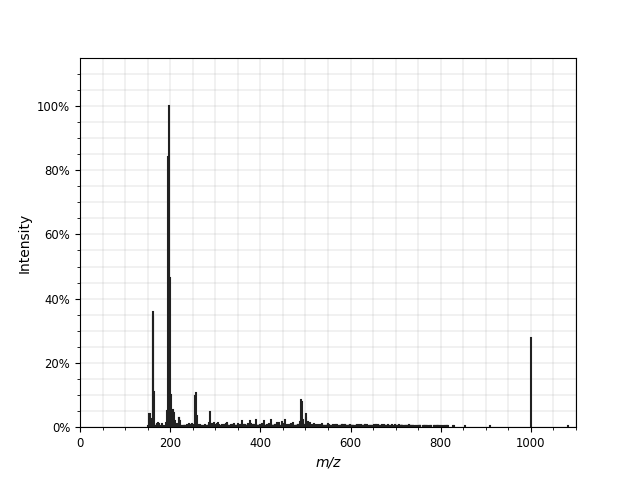

In [30]:
# Test-Plot of a spectrum containing the spot-intensity matching its RT
test=5004
print("MS-Level: ",exp[test].getMSLevel())
fig,ax=plt.subplots()
plot_spectrum(exp[test])

[Text(0.5, 1.0, 'Bioactivity Chromatogramm Spot-Intensities')]

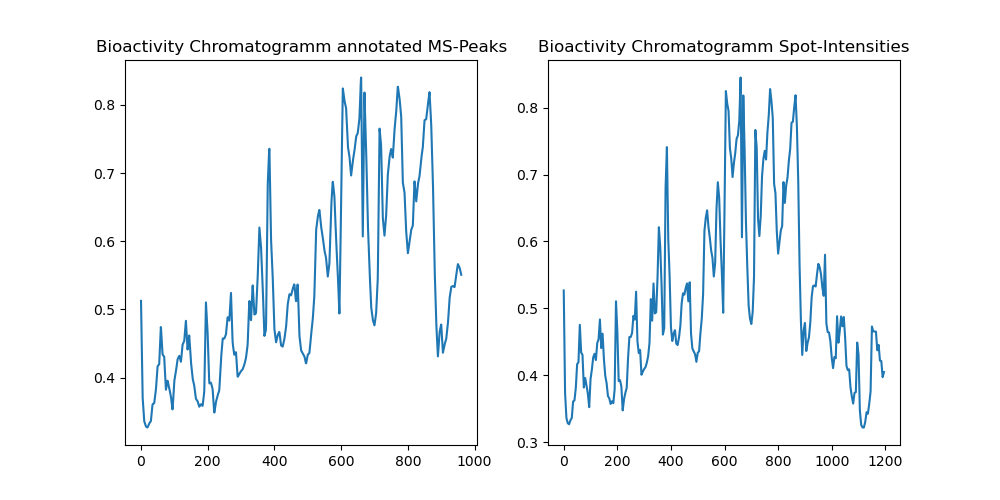

In [31]:
# Comparison of the chromatogramms of the spotlist and the annotated mass spectra.

fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(rt_list,int_list)
ax[0].set(title="Bioactivity Chromatogramm annotated MS-Peaks")
ax[1].plot(spots["RT"],spots["spot_intensity"])
ax[1].set(title="Bioactivity Chromatogramm Spot-Intensities")